In [1]:
import numpy as np
import pandas as pd
import random
import string
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import math
import json
from nltk import tokenize
import collections
import re
import itertools
import nltk
from scipy.stats import mannwhitneyu

import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel,\
        GenericLikelihoodModelResults

from statsmodels.nonparametric.smoothers_lowess import lowess

from scipy.special import zeta
from scipy.stats import binom

import pickle
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

lg = np.log10

In [4]:
web_train_20000 = pickle.load(open("datasets/web_train_20000.p", "rb" ))

In [5]:
gpt_train_20000 = pickle.load(open("datasets/gpt_train_20000.p", "rb" ))

# Subsampling

In [6]:
# Returns 2 lists of corpora, one from which the ranks will be calculated
# and one from which the frequencies will be calculated. Each corpus consists of
# a list of tokenized sentences.
# Input: corpus that is to be subsampled. Should be a list of tokenized sentences.
# k is the amount of tokens that each sampled corpus should contain,
# m is the amount of subcorpera you want for both the ranks and frequencies.
# Max: I would read Valentin's thesis for an explanation on subsampling
def subsampling(corpus, k = 1000000, m = 10, sent = True):
    n = len(corpus)
    
    sen_len = {}

    
    rank_corpera = []
    freq_corpera = []

    if sent:
        for i in range(m):
            used_rank = set()
            used_freq = set()
            rank_count = 0
            freq_count = 0
            rank_samples = []
            freq_samples = []

            while rank_count < k:
                index = np.random.randint(n)
                if index in used_rank:
                    continue

                rank_sample = corpus[index]
                len_sample = len(rank_sample)

                if len_sample == 0:
                    continue

                if rank_count > k:
                    max_len = len_sample - (rank_count - k)
                    rank_sample = rank_sample[:max_len]
                    
                rank_samples += rank_sample
                rank_count += len_sample


                used_rank.add(index)

            while freq_count < k:
                index = np.random.randint(n)
                if index in used_freq:
                    continue
                freq_sample = corpus[index]
                len_sample = len(freq_sample)

                if len_sample == 0:
                    continue
                    
                if freq_count > k:
                    max_len = len_sample - (freq_count - k)
                    freq_sample = freq_sample[:max_len]

                freq_samples += freq_sample
                freq_count += len_sample

                if len_sample not in sen_len and len_sample < 200:
                    sen_len[len_sample] = 1
                elif len_sample < 200:
                    sen_len[len_sample] += 1

                used_freq.add(index)

            rank_corpera.append(rank_samples)
            freq_corpera.append(freq_samples)
#                 rank_corpera.append([item for sublist in rank_samples for item in sublist])
#                 freq_corpera.append([item for sublist in freq_samples for item in sublist])


    else:
        for i in range(m):
            rank_samples = random.sample(corpus, k)
            freq_samples = random.sample(corpus, k)
            rank_corpera.append(rank_samples)
            freq_corpera.append(freq_samples)
    
#     return rank_corpera, freq_corpera, sen_len
    return rank_corpera, freq_corpera

# Rank-Frequency calculations

In [7]:
# Returns a dataframe of word frequencies for list of corpora,
# with each column corresponding to a different corpus.
# Input: list of corpora. Each corpus consists of a list of tokenized sentences.
def calculate_freqs(freq_sents, norm=True, text=None):
    freq_dict = {}
    norm_dict = {}
    for i, corpus in enumerate(freq_sents):
        freq_dict['{} c_frequency {}'.format(text,i)] = collections.Counter(corpus)
        if norm:
            len_corp = len(corpus)
            norm_dict['{} c_frequency {}'.format(text, i)] = {k: v / len_corp for k, v in freq_dict['{} c_frequency {}'.format(text,i)].items()}
    
    if norm:
        freqs_df = pd.DataFrame(norm_dict)
    else:
        freqs_df = pd.DataFrame(freq_dict)
    freqs_df = freqs_df.fillna(0)
    
    
    return freqs_df

In [8]:
# Returns a dataframe with the mean frequency of each word across different corpora.
# Input: frequency dataframe
def mean_freqs(freqs_df):
    return(freqs_df.mean(axis=1))

In [9]:
# Returns a dataframe of word ranks for list of corpora,
# with each column corresponding to a different corpus.
# Input: list of corpora. Each corpus consists of a list of tokenized sentences.
def calculate_ranks(rank_sents, norm=False, text=None):
    ranks_dicts = {}
    for i, corpus in enumerate(rank_sents):
        freqs = collections.Counter(corpus)
        if norm:
            len_corp = len(corpus)
            for key in freqs:
                freqs[key] /= len_corp
        ranks_dicts['{} c_rank {}'.format(text, i)] = {w: r for r, (w, c) in enumerate(freqs.most_common(), 1)}
    
    ranks_df = pd.DataFrame(ranks_dicts)
    for column in ranks_df:
        min_rank = int(np.ceil(ranks_df[column].max() + 1))
        nan_rows = ranks_df[ranks_df[column].isnull()]
        num_nans = len(nan_rows)
        nan_ranks = list(range(min_rank, min_rank+num_nans))
        random.shuffle(nan_ranks)
        ranks_df.loc[ranks_df[column].isnull(), column] = nan_ranks

    return ranks_df

In [10]:
# Returns a dataframe with the mean rank of each word across different corpora.
# Input: rank dataframe
def mean_ranks(ranks_df):
    return ranks_df.mean(axis=1)

In [11]:
# Creates combined dataframe of ranks and frequencies
# Input: 2 lists (freq_sents and rank_sents) of corpora. Each corpus
# consists of a list of tokenized sentences. These lists are to be obtained form
# subsampling.
def ranks_freqs(freq_sents, rank_sents, text=None, norm=False):
    freqs_df = calculate_freqs(freq_sents, text=text, norm=norm)
    freqs_df['Frequency'] = mean_freqs(freqs_df)
    ranks_df = calculate_ranks(rank_sents, text=text, norm=norm)
    ranks_df['Rank'] = mean_ranks(ranks_df)
    
    
    # Put mean ranks and freqs together and remove all words that
    # do not have both a rank and frequency (which happens when a word)
    # is only present in freq_sents and not in rank_sents or vice versa
    ranks_freqs_df = pd.concat([ranks_df, freqs_df], axis = 1)
    ranks_freqs_df = ranks_freqs_df.dropna()
#     ranks_freqs_df = ranks_freqs_df.loc[ranks_freqs_df['Frequency'] >=1]
    return ranks_freqs_df

# Zipf's law

In [12]:
# MLE of Zipf's law parameters (alpha and beta)
class Mandelbrot(GenericLikelihoodModel):

    def __init__(self, frequencies, ranks, **kwargs):
        if not len(frequencies) == len(ranks):
            raise ValueError("NOT THE SAME NUMBER OF RANKS AND FREQS!")
        
        frequencies = np.asarray(frequencies)
        ranks = np.asarray(ranks)
        
        self.n_obs = np.sum(frequencies)
        
        super().__init__(endog=frequencies, exog=ranks, **kwargs)
        self.fit_result = None
    

    def prob(self, params, ranks=None, log=False):
        if ranks is None:
            ranks = self.exog
        
        alpha, beta = params
        if log:
            return -alpha*lg(beta+ranks) - lg(zeta(alpha, q=beta+1.))
        else:
            return ((beta + ranks)**(-alpha))/zeta(alpha, q=beta+1.)
    
    
    def loglike(self, params):
        rs = self.exog
        fs = self.endog
        alpha, beta = params
        
#        if alpha > 10 or beta > 20:
#            return -np.inf
        
#         if alpha < 1.0 or beta < 0.0:
#             return -np.inf
        
        # no need to calculate P(r) when observed f(r) was zero
        log_probs = -alpha*lg(beta+rs) - lg(zeta(alpha, q=beta+1.))
        log_probs = log_probs.reshape(-1, )
        return np.sum(fs * log_probs) - beta**5
    
    
    def register_fit(self, fit_result, overwrite=False):
        if not self.fit_result is None and not overwrite:
            raise ValueError("A fit result is already registered and overwrite=False!")
            
        self.fit_result = fit_result
        self.optim_params = fit_result.params
        self.pseudo_r_squared = self.pseudo_r_squared(self.optim_params)
        self.SE, self.SE_relative = fit_result.bse, fit_result.bse/self.optim_params
        self.BIC, self.BIC_relative = fit_result.bic,\
                            (-2*self.null_loglike())/fit_result.bic
        
        return self.optim_params
    
    def print_result(self, string=False):
        if self.fit_result is None:
            raise ValueError("Register a fitting result first!")

        def format_x(x):
            return float('{0:.3g}'.format(x))


        s = "="*50
        s += "\n" + "MANDELBROT"
        s += "\n" + "  Optimal Parameters " + str(tuple(map(format_x, self.optim_params)))
        
        s += "\n" + "  Standard Error [relative]: " + str(tuple(map(format_x, self.SE))) +\
              ", [" + str(tuple(map(format_x, self.SE_relative))) + "]"
        
        s += "\n" + "  Pseudo R^2: " + str(format_x(self.pseudo_r_squared))
        
        s += "\n" + "  BIC [relative]: " + str(format_x(self.BIC)) +\
              ", [" + str(format_x(self.BIC_relative)) + "]"
        s += "\n" + "="*50
        
        if string:
            return s
        
        print(s)
    
    
    def null_loglike(self, epsilon=1e-10):
        return self.loglike((1.+epsilon, 0.0))
    
    def pseudo_r_squared(self, params):
        return 1-self.loglike(params)/self.null_loglike()
    
    
    def predict(self, params, ranks=None, freqs=True, n_obs=None, 
                correct_for_finite_domain=True):
        if ranks is None:
            ranks = self.exog
        ranks = np.asarray(ranks)
        
        if n_obs is None:
            n_obs = self.n_obs
            
        alpha, beta = params
        pred_probs = self.prob(params, ranks=ranks, log=False)
        
        if correct_for_finite_domain:
            if not freqs:
                raise NotImplementedError("Correction for "\
                                          "finite domain not implemented with probabilities!")
            return pred_probs*(n_obs/np.sum(pred_probs))
        
        if freqs:
            return n_obs*pred_probs
        
        return pred_probs




In [61]:
# Returns a dataframe containing the mean frequencies and ranks, as well as 
# the estimated frequencies from Zipf's law and the error between the (log) mean
# frequencies and (log) estimated frequencies.
def zipfs_law(df, print_stats = True):
    mandelbrot = Mandelbrot(df['Frequency'], df['Rank'])
    mandelbrot_fit = mandelbrot.fit(start_params=np.asarray([1.0, 1.0]), # [1.0, 1.0]
                                method="powell", full_output=True, disp=0)
    mandelbrot.register_fit(mandelbrot_fit)
    if print_stats:
        mandelbrot.print_result()
    
    model_params = mandelbrot.optim_params
    alpha, beta =  mandelbrot.optim_params
    preds = mandelbrot.predict(model_params, df['Rank'])

    df['Estimated frequency'] = preds
    df['Rank (log)'] = np.log(df['Rank'])
    df['Frequency (log)'] = np.log(df['Frequency'])
    df['Estimated frequency (log)'] = np.log(df['Estimated frequency'])
    df['Error'] = df['Frequency (log)'] - df['Estimated frequency (log)']
    return df

# Plotting code

In [14]:
def get_lims(xs, ys, log=False, equal_aspect=False):
    lows = min(xs), min(ys)
    highs = max(xs), max(ys)
    
    if log:
        c_low, c_high = (lambda x: x*0.5), (lambda x: x*1.5)   
    else:
        c_low, c_high = (lambda x: x*0.6), (lambda x: x*1.05)   
    
    if log:
        lows = tuple(max(10**-10, l) for l in lows)
    
    if equal_aspect:
        lims = (c_low(min(lows)),)*2, (c_high(max(highs)),)*2
        return list(zip(*lims))
    
    return (c_low(lows[0]), c_high(highs[0])),\
                (c_low(lows[1]), c_high(highs[1]))

In [15]:
def remove_zeros(x_vals, y_vals):
    return list(zip(*[(x, y) for x, y in zip(x_vals, y_vals) 
                      if x > 0 and y > 0]))

In [16]:
def type_plot(df, word_type, xlbl=None, ylbl=None, log=True,
                ignore_zeros=True, cbar=True,
                set_aspect=False, lims=None, equal_aspect=False, min_y=None,
                **plt_args):
    xs = df['Rank']
    ys = df['Frequency']
    est = df['Estimated frequency']
    
    if min_y is not None:
        xs, ys = list(zip(*[(x, y) for x, y in zip(xs, ys) if y >= min_y]))
    
    if not lims:
        lims = get_lims(xs, ys, log=log)
    
    
    if ignore_zeros:
        xs, ys = remove_zeros(xs, ys)

    params = dict(cmap='Blues_r', edgecolors="blue", gridsize=75, mincnt=1,
                  linewidths=0.2)
    if log:
        params.update(dict(bins="log", xscale="log", yscale="log"))
    else:
        plt.ticklabel_format(style="sci", axis="both", 
                             scilimits=(0, 0))
    params.update(plt_args)    

    hb = plt.hexbin(xs, ys, **params)
    
    type_df = df.query('ilevel_1 == @word_type')
    params2 = dict(cmap='Blues_r', edgecolors="blue", gridsize=75, mincnt=1,
                linewidths=0.2)
    hb2 = plt.hexbin(type_df['Rank'], type_df['Frequency'], **params2)
    
    lims_x, lims_y = lims
    plt.xlim(lims_x)
    plt.ylim(lims_y)
    
    if cbar:
        plt.gcf().colorbar(hb)
        plt.gcf().colorbar(hb2)
    
    if xlbl:
        plt.xlabel(xlbl)
    if ylbl:
        plt.ylabel(ylbl)
        
    plt.plot(xs, est, color='r', linestyle="--")
        
    return lims

In [100]:
def hexbin_plot2(xs, ys, est=None, word_type=None,xlbl="$r(w)$", 
                ylbl="$f(w)$", log=True,
                ignore_zeros=True, cbar=True,
                set_aspect=False, lims=None, equal_aspect=False, min_y=None,
                **plt_args):
    
    
    if min_y is not None:
        xs, ys = list(zip(*[(x, y) for x, y in zip(xs, ys) if y >= min_y]))
    
    if not lims:
        lims = get_lims(xs, ys, log=log)
    
    
    if ignore_zeros:
        xs, ys = remove_zeros(xs, ys)

    params = dict(cmap='Blues_r', edgecolors="blue", gridsize=75, mincnt=1,
                  linewidths=0.2)
    if log:
        params.update(dict(bins="log", xscale="log", yscale="log"))
    else:
        plt.ticklabel_format(style="sci", axis="both", 
                             scilimits=(0, 0))
    params.update(plt_args)    

    hb = plt.hexbin(xs, ys, **params)
    
    if word_type:
        type_df = df.query('ilevel_1 == @word_type')
        params2 = dict(color = 'red', gridsize=75, mincnt=1,
                  linewidths=0.2)
        plt.hexbin(type_df['Rank'], type_df['Frequency'], **params2)
    
    lims_x, lims_y = lims
    plt.xlim(lims_x)
    plt.ylim(lims_y)
    
    if cbar:
        plt.gcf().colorbar(hb)

    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
        
    if est is not None:
        plt.plot(xs, est, color='#E995FD', linestyle="--", linewidth=2)
        
        
    return lims

In [72]:
def hexbin_plot(xs, ys, corp, size, est=None, word_type=None, xlbl="$r(w)$", 
                ylbl="$f(w)$", log=True,
                ignore_zeros=True, cbar=True,
                set_aspect=False, lims=None, equal_aspect=False, min_y=None,
                **plt_args):
    
    
    if min_y is not None:
        xs, ys = list(zip(*[(x, y) for x, y in zip(xs, ys) if y >= min_y]))
    
    if not lims:
        lims = get_lims(xs, ys, log=log)
    
    
    if ignore_zeros:
        xs, ys = remove_zeros(xs, ys)

    params = dict(cmap='Blues_r', edgecolors="blue", gridsize=75, mincnt=1,
                  linewidths=0.2)
    if log:
        params.update(dict(bins="log", xscale="log", yscale="log"))
    else:
        plt.ticklabel_format(style="sci", axis="both", 
                             scilimits=(0, 0))
    params.update(plt_args)    

    hb = plt.hexbin(xs, ys, **params)
    
    if word_type:
        type_df = df.query('ilevel_1 == @word_type')
        params2 = dict(color = 'red', gridsize=75, mincnt=1,
                  linewidths=0.2)
        plt.hexbin(type_df['Rank'], type_df['Frequency'], **params2)
    
    lims_x, lims_y = lims
    plt.xlim(lims_x)
    plt.ylim(lims_y)
    
    plt.xlabel("")
    
    if cbar:
        plt.gcf().colorbar(hb)
    
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
        
    if est is not None:
        plt.plot(xs, est, color='r', linestyle="--")
        
    plt.savefig("zipf/zipf_" + corp + "_" + str(size) + ".png",
                    dpi=300)
    plt.show()
    plt.close()
        
    return lims

In [73]:
def hexbin_error2(xs, ys, xlbl="$\log$ $r(w)$", 
                ylbl="$\log$ $f_{error}(w)$",
                ignore_zeros=True, cbar=True,
                set_aspect=False, lims=None, equal_aspect=False, min_y=None,
                **plt_args):
    

    # cmap='cividis'
    params = dict(cmap='Blues_r', edgecolors="blue", gridsize=75, mincnt=1,
                  linewidths=0.2)

    plt.ticklabel_format(style="sci", axis="both", 
                            scilimits=(0, 0))
    params.update(plt_args)    

    hb = plt.hexbin(xs, ys, **params)
    
    if cbar:
        plt.gcf().colorbar(hb)
    
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    
    plt.ylim([-2,2])
        
    plt.axhline(linewidth=1.5, color='r', linestyle="--")
        
    return None

In [89]:
def hexbin_error(xs, ys, corp, size, xlbl="$\log$ $r(w)$", 
                ylbl="$\log$ error",
                ignore_zeros=True, cbar=True,
                set_aspect=False, lims=None, equal_aspect=False, min_y=None,
                **plt_args):
    

    # cmap='cividis'
    params = dict(cmap='Blues_r', edgecolors="blue", gridsize=75, mincnt=1,
                  linewidths=0.2)

    plt.ticklabel_format(axis="both", 
                            scilimits=(0, 0))
    params.update(plt_args)    

    hb = plt.hexbin(xs, ys, **params)
    
    if cbar:
        plt.gcf().colorbar(hb)
    
    if xlbl:
        plt.xlabel(xlbl)
    if ylbl:
        plt.ylabel(ylbl)
    
    plt.ylim([-2,2])
#     ax.ticklabel_format(useOffset=False)
        
    plt.axhline(linewidth=1.5, color='r', linestyle="--")
    
    plt.savefig("error/error_" + corp + "_" + str(size) + ".png",
                    dpi=300)
    
    plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
    plt.show()
    plt.close()
        
    return None

In [102]:
def plot_type_zipf(df, pos_query, n_pos_query, pos, gpt):
#     df = df.loc[df['Frequency'] >=1]
    df = df.sort_values(by=['Rank'])
    type_df = df.query(pos_query)
    rest_df = df.query(n_pos_query)
    type_df = zipfs_law(type_df)
    hexbin_plot2(rest_df['Rank'], rest_df['Frequency'], est=None, xlbl=r"$r(w)$", ylbl=r"$f(w)$", cbar=False)
    hexbin_plot2(type_df['Rank'], type_df['Frequency'], est=type_df['Estimated frequency'], xlbl=r"$r(w)$", ylbl=r"$f(w)$", 
                color="red", edgecolors="red", cmap="Reds_r", cbar=True)
    plt.savefig("poszipf/zipf_" + gpt + "_" + pos + ".png", dpi=300)
    plt.show()
    plt.close()
    

#     hexbin_error2(rest_df['Rank (log)'], rest_df['Error'])
#     hexbin_error2(type_df['Rank (log)'], type_df['Error'], color="red", edgecolors="red", cmap="Reds_r")
#     plt.savefig("poserror/error_" + gpt + "_" + pos + ".png", dpi=300)
    
#     plt.show()
#     plt.close()
    
    return type_df, rest_df

In [68]:
def plot_zipf(ranks_freqs_df, corp, size):
    ranks_freqs_df = ranks_freqs_df.sort_values(by=['Rank'])
    zipf_df = zipfs_law(ranks_freqs_df)
#     ranks_freqs_df = ranks_freqs_df.loc[ranks_freqs_df['Frequency'] >=1]
    hexbin_plot(ranks_freqs_df['Rank'], ranks_freqs_df['Frequency'], corp, size, est = ranks_freqs_df['Estimated frequency'])
    plt.show()
    hexbin_error(zipf_df['Rank (log)'], zipf_df['Error'], corp, size)
    plt.show()
    
    return zipf_df

In [25]:
def freq_of_freqs_hexbin_plot(freqs):
    freq_of_freqs = collections.Counter(freqs)
    hexbin_plot(list(freq_of_freqs.keys()), freq_of_freqs.values())
    plt.show()
    return None

In [26]:
def fano_factor(ranks_freqs_df, ylim = None, n=10):
    fano = []

    for index, row in ranks_freqs_df.iterrows():
        fano.append((np.cov(row[0:n], row[n+1:2*n +1])[0][1])/row['Rank'])
    ranks_freqs_df['Fano'] = fano
#     fano_plot(ranks_freqs_df, ylim=ylim)
    return ranks_freqs_df

In [27]:
noun_query = "ilevel_1 == 'NN' or ilevel_1 == 'NNS' or ilevel_1 == 'NNP'"
verb_query = "ilevel_1 == 'VB' or ilevel_1 == 'VBD' or ilevel_1 == 'VBG' or ilevel_1 == 'VBN' or ilevel_1 == 'VBP' or ilevel_1 == 'VBZ'"
adj_query = "ilevel_1 == 'JJ' or ilevel_1 == 'JJR' or ilevel_1 == 'JJS'"
adv_query = "ilevel_1 == 'RB' or ilevel_1 == 'RBR' or ilevel_1 == 'RBS'"

n_noun_query = "ilevel_1 != 'NN' and ilevel_1 != 'NNS' and ilevel_1 != 'NNP'"
n_verb_query = "ilevel_1 != 'VB' and ilevel_1 != 'VBD' and ilevel_1 != 'VBG' and ilevel_1 != 'VBN' and ilevel_1 != 'VBP' and ilevel_1 != 'VBZ'"
n_adj_query = "ilevel_1 != 'JJ' and ilevel_1 != 'JJR' and ilevel_1 != 'JJS'"
n_adv_query = "ilevel_1 != 'RB' and ilevel_1 != 'RBR' and ilevel_1 != 'RBS'"

In [28]:
def plotting_wrong(corpus, corp):
    num_corp = len(corpus)
    corpus = [item for sublist in corpus for item in sublist]
    corpus = [item for sublist in corpus for item in sublist]
    freqs = collections.Counter(corpus)
    freqs_df = pd.DataFrame.from_dict(freqs, orient='index')
    freqs_df = freqs_df.rename(columns={0:'Frequency'})
    freqs_df['Frequency'] = freqs_df['Frequency'] / len(corpus)
#     freqs_df = freqs_df.fillna(0)
    freqs_df['Rank'] = freqs_df.rank(method='first', ascending=False)
    freqs_df = freqs_df.sort_values(by=['Rank'])
    zipf_df = zipfs_law(freqs_df)
    hexbin_plot(zipf_df['Rank'], zipf_df['Frequency'], "wrong", 1000, est = zipf_df['Estimated frequency'])
    plt.show()
    return zipf_df

In [ ]:
plotting_wrong(web_train_20000[:1000], "web_wrong")

MANDELBROT
  Optimal Parameters (1.2, 0.311)
  Standard Error [relative]: (0.3, 1.23), [(0.251, 3.95)]
  Pseudo R^2: 0.711
  BIC [relative]: 18.3, [1.35]


OPEN<br>
NN = noun, common, singular or mass<br>
NNS = noun, common, plural<br>
NNP = noun, proper, singular<br><br>

VBD = verb, past tense<br>
VBP = verb, present tense, not 3rd person singular<br>
VBG = verb, present participle or gerund<br>
VB = verb, base form<br>
VBZ = verb, present tense, 3rd person singular <br>
VBN = verb, past participle<br><br>

JJ = adjective or numeral, ordinal<br>
JJR = adjective, comparative<br>
JJS = adjective, superlative<br><br>

RB: adverb<br>
RBR: adverb, comparative<br>
RBS: adverb, superlative<br><br>

# Experiments

In [69]:
# 'corpus' is dus een lijst van tokenized zinnen. k en m kan je zelf invullen of 
# default gebruiken.
def plotting(corpus, corp, m=10):
    num_corp = len(corpus)
    corpus = [item for sublist in corpus for item in sublist]
    rank_corp, freq_corp = subsampling(corpus, m=m, k=num_corp*100)
    ranks_freqs_df = ranks_freqs(rank_corp, freq_corp, norm=False)
    zipf_df = plot_zipf(ranks_freqs_df, corp, num_corp)
    return zipf_df

In [30]:
def plotting_pos(corpus, pos_query, n_pos_query, pos, gpt):
    num_corp = len(corpus)
    corpus = [item for sublist in corpus for item in sublist]
    rank_corp, freq_corp = subsampling(corpus, k=num_corp*100)
    ranks_freqs_df = ranks_freqs(rank_corp, freq_corp)
    type_df, rest_df = plot_type_zipf(ranks_freqs_df, pos_query, n_pos_query, pos, gpt)
    return type_df, rest_df

In [31]:
def plotting_lone(corpus, pos_query, corp, m=10):
    num_corp = len(corpus)
    corpus = [item for sublist in corpus for item in sublist]
    rank_corp, freq_corp = subsampling(corpus, m=m, k=num_corp*100)
    ranks_freqs_df = ranks_freqs(rank_corp, freq_corp, norm=False)
    ranks_freqs_df = ranks_freqs_df.query(pos_query)
    zipf_df = plot_zipf(ranks_freqs_df, corp, num_corp)
    return zipf_df

# Web plots

MANDELBROT
  Optimal Parameters (1.26, 1.01)
  Standard Error [relative]: (0.0383, 0.206), [(0.0303, 0.205)]
  Pseudo R^2: 0.757
  BIC [relative]: 653.0, [4.08]


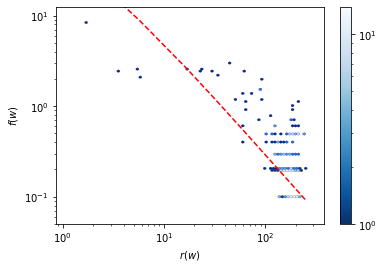

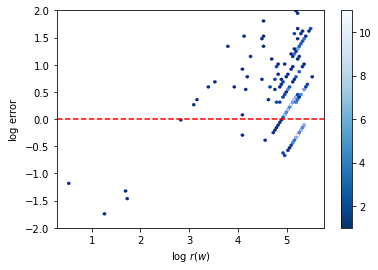

In [78]:
zipf_web_1 = plotting(web_train_20000[:1], "web")

MANDELBROT
  Optimal Parameters (1.27, 1.03)
  Standard Error [relative]: (0.0406, 0.198), [(0.0319, 0.192)]
  Pseudo R^2: 0.763
  BIC [relative]: 609.0, [4.18]


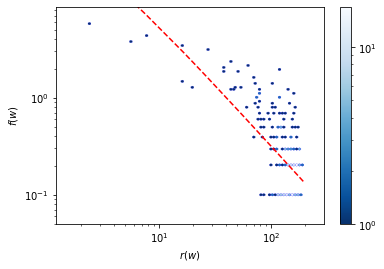

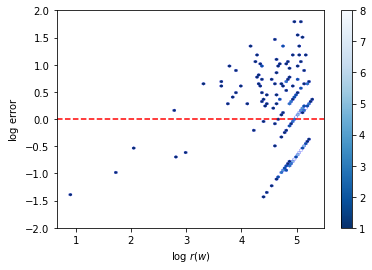

In [79]:
zipf_gpt_1 = plotting(gpt_train_20000[:1], "gpt")

MANDELBROT
  Optimal Parameters (1.22, 1.34)
  Standard Error [relative]: (0.0111, 0.129), [(0.0091, 0.0964)]
  Pseudo R^2: 0.73
  BIC [relative]: 6260.0, [3.69]


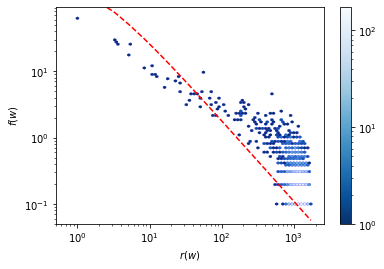

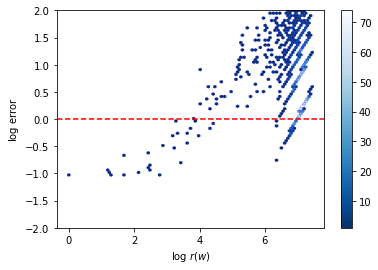

In [80]:
zipf_web_10 = plotting(web_train_20000[:10], "web")

MANDELBROT
  Optimal Parameters (1.2, 1.91)
  Standard Error [relative]: (0.00317, 0.0714), [(0.00265, 0.0374)]
  Pseudo R^2: 0.714
  BIC [relative]: 68200.0, [3.5]


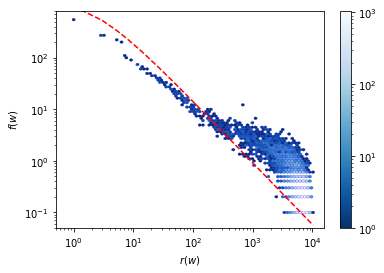

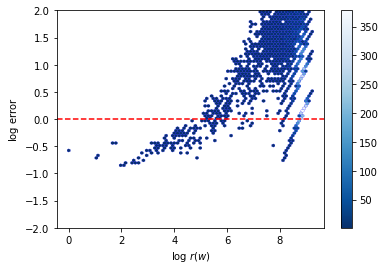

In [81]:
zipf_web_100 = plotting(web_train_20000[:100], "web")

MANDELBROT
  Optimal Parameters (1.19, 2.65)
  Standard Error [relative]: (0.001, 0.0391), [(0.00084, 0.0147)]
  Pseudo R^2: 0.711
  BIC [relative]: 707000.0, [3.46]


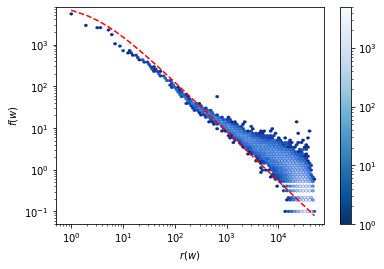

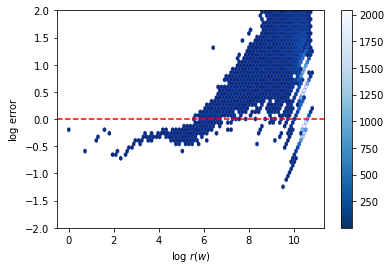

In [90]:
zipf_web_1000 = plotting(web_train_20000[:1000], "web")

MANDELBROT
  Optimal Parameters (1.19, 3.29)
  Standard Error [relative]: (0.000333, 0.0204), [(0.00028, 0.00622)]
  Pseudo R^2: 0.711
  BIC [relative]: 7140000.0, [3.45]


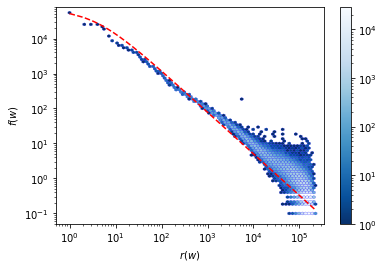

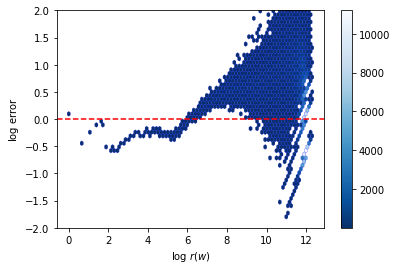

In [91]:
zipf_web_10000 = plotting(web_train_20000[:10000], "web")

# GPT plots

MANDELBROT
  Optimal Parameters (1.25, 1.44)
  Standard Error [relative]: (0.0125, 0.117), [(0.01, 0.0817)]
  Pseudo R^2: 0.751
  BIC [relative]: 5800.0, [4.01]


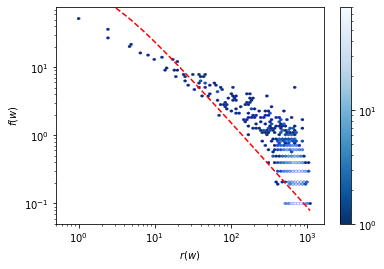

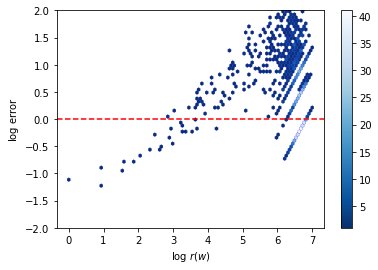

In [92]:
zipf_gpt_10 = plotting(gpt_train_20000[:10], "gpt")

MANDELBROT
  Optimal Parameters (1.24, 2.05)
  Standard Error [relative]: (0.00381, 0.0653), [(0.00308, 0.0318)]
  Pseudo R^2: 0.743
  BIC [relative]: 60400.0, [3.89]


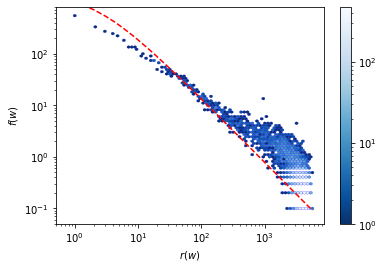

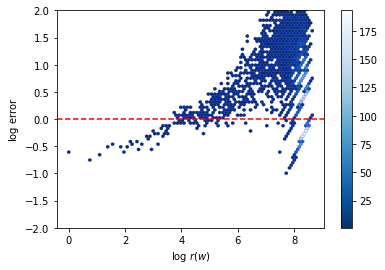

In [93]:
zipf_gpt_100 = plotting(gpt_train_20000[:100], "gpt")

MANDELBROT
  Optimal Parameters (1.23, 2.87)
  Standard Error [relative]: (0.00122, 0.0358), [(0.000991, 0.0125)]
  Pseudo R^2: 0.742
  BIC [relative]: 616000.0, [3.87]


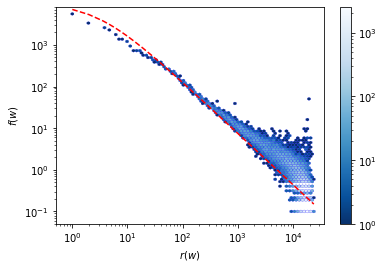

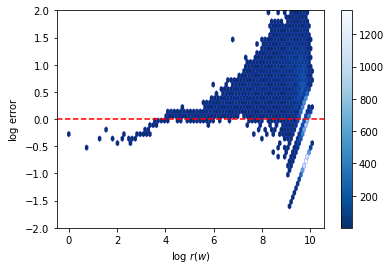

In [94]:
zipf_gpt_1000 = plotting(gpt_train_20000[:1000], "gpt")

In [95]:
zipf_gpt_10000 = plotting(gpt_train_20000[:10000], "gpt")

KeyboardInterrupt: 

PoS

MANDELBROT
  Optimal Parameters (1.14, 3.75)
  Standard Error [relative]: (0.000752, 0.028), [(0.000662, 0.00746)]
  Pseudo R^2: 0.656
  BIC [relative]: 719000.0, [2.9]


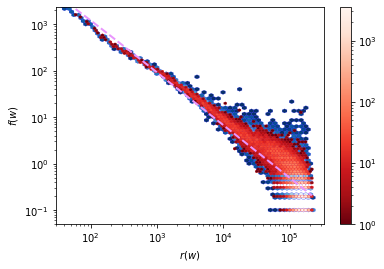

In [103]:
adj_web = plotting_pos(web_train_20000[:10000], adj_query, n_adj_query, "adj", "web")

MANDELBROT
  Optimal Parameters (1.16, 3.8)
  Standard Error [relative]: (0.000922, 0.0274), [(0.000793, 0.00722)]
  Pseudo R^2: 0.686
  BIC [relative]: 591000.0, [3.19]


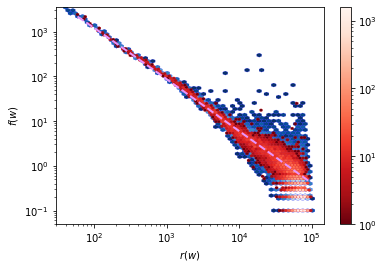

In [104]:
adj_gpt = plotting_pos(gpt_train_20000[:10000], adj_query, n_adj_query, "adj", "gpt")

MANDELBROT
  Optimal Parameters (1.19, 3.49)
  Standard Error [relative]: (0.00135, 0.0309), [(0.00114, 0.00884)]
  Pseudo R^2: 0.714
  BIC [relative]: 336000.0, [3.5]


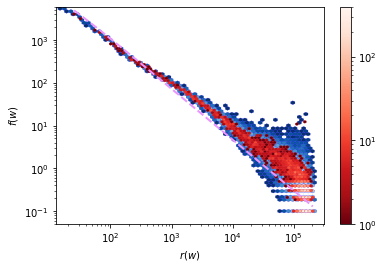

In [105]:
adv_web = plotting_pos(web_train_20000[:10000], adv_query, n_adv_query, "adv", "web")

MANDELBROT
  Optimal Parameters (1.22, 3.58)
  Standard Error [relative]: (0.00151, 0.0296), [(0.00124, 0.00828)]
  Pseudo R^2: 0.738
  BIC [relative]: 325000.0, [3.82]


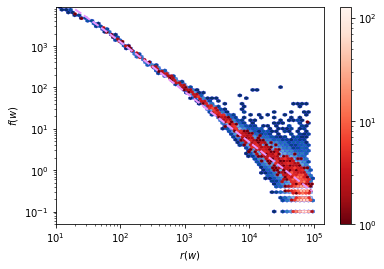

In [106]:
adv_gpt = plotting_pos(gpt_train_20000[:10000], adv_query, n_adv_query, "adv", "gpt")

MANDELBROT
  Optimal Parameters (1.13, 4.92)
  Standard Error [relative]: (0.000351, 0.0186), [(0.000311, 0.00378)]
  Pseudo R^2: 0.641
  BIC [relative]: 3030000.0, [2.78]


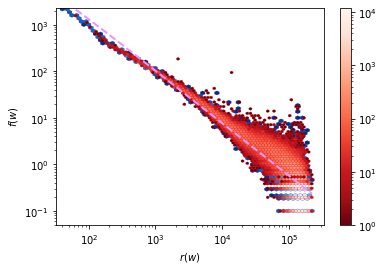

In [107]:
noun_web = plotting_pos(web_train_20000[:10000], noun_query, n_noun_query, "noun", "web")

MANDELBROT
  Optimal Parameters (1.14, 4.78)
  Standard Error [relative]: (0.000449, 0.0194), [(0.000392, 0.00406)]
  Pseudo R^2: 0.666
  BIC [relative]: 2160000.0, [3.0]


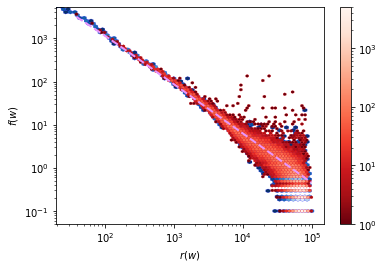

In [108]:
noun_gpt = plotting_pos(gpt_train_20000[:10000], noun_query, n_noun_query, "noun", "gpt")

MANDELBROT
  Optimal Parameters (1.17, 4.04)
  Standard Error [relative]: (0.000645, 0.0241), [(0.000553, 0.00598)]
  Pseudo R^2: 0.69
  BIC [relative]: 1260000.0, [3.22]


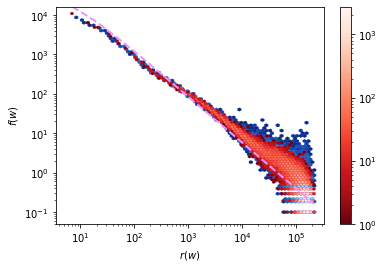

In [109]:
verb_web = plotting_pos(web_train_20000[:10000], verb_query, n_verb_query, "verb", "web")

MANDELBROT
  Optimal Parameters (1.2, 4.27)
  Standard Error [relative]: (0.000744, 0.0222), [(0.000619, 0.0052)]
  Pseudo R^2: 0.723
  BIC [relative]: 1210000.0, [3.61]


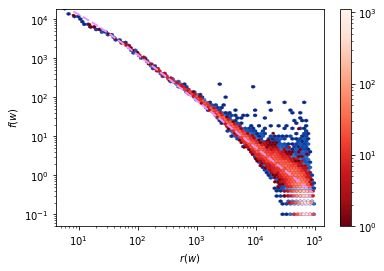

In [110]:
verb_gpt = plotting_pos(gpt_train_20000[:10000], verb_query, n_verb_query, "verb", "gpt")

In [343]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set default font family and dpi
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
rcParams['figure.dpi'] = 150

In [344]:
# Load data from CSV file
df = pd.read_csv('jema.csv', index_col=0, header=[0,1])
df.index.name = 'bin'
df

IndexError: list index out of range